# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '../../../../Downloads/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

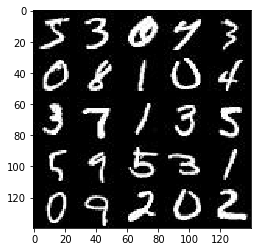

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

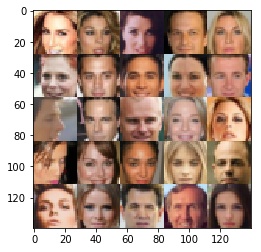

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_images')
    z_data = tf.placeholder(tf.float32, shape = [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    keep_prob = tf.constant(0.7, dtype=tf.float32)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        x3 = tf.maximum(alpha * x3, x3)
        # 3x3x256
        
        flat = tf.reshape(x3, (-1, 3*3*256) )
        drop = tf.nn.dropout(flat, keep_prob)
        
        logits = tf.layers.dense(drop, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')  # valid -> size: 2 * 3 + 1
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize 
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    # http://ruishu.io/2016/12/27/batchnorm/
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # show stats every 10 batches
                if batch_i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show images every 100 batches
                if batch_i % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
            # end of Epoch images
            # print('State of the art after epoch', epoch_i+1)
            # show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.5305... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.7732


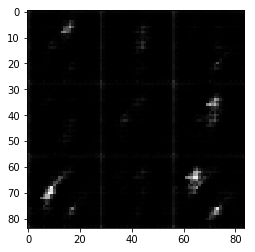

Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.8290
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.8218


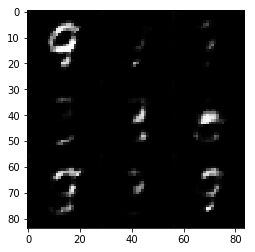

Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.8955
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7579


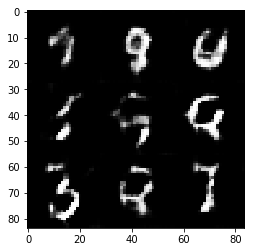

Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.7291
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.4903
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.9215
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.7889


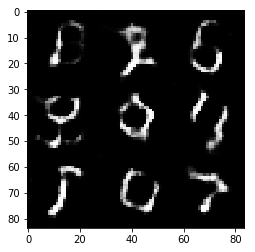

Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.8542
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.9234
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.9506


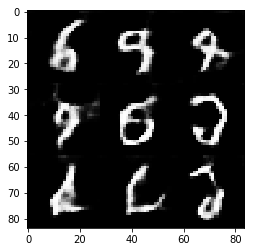

Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.7291
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.8852


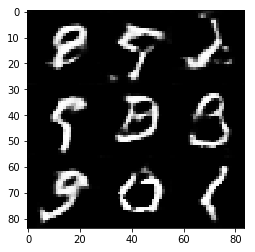

Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 1.4723... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.8120


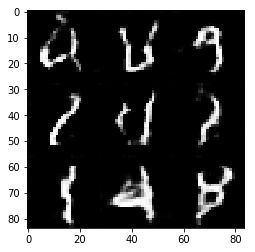

Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.9132


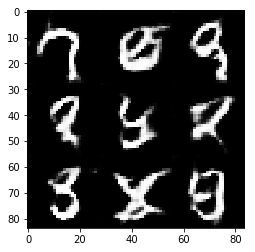

Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.8712
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.7653


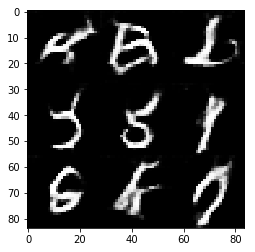

Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.9237


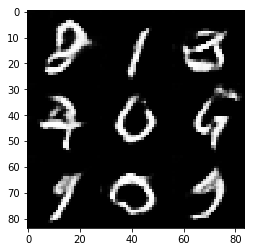

Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.3175... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 1.1303
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.8231
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.8704


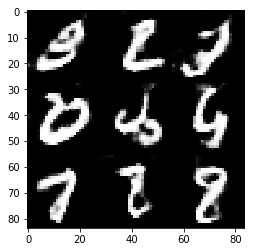

Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.2511... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 1.4793... Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.8405


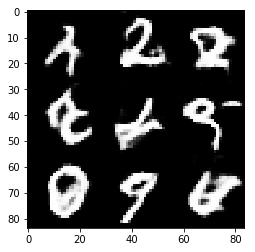

Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 1.3440
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 1.0034


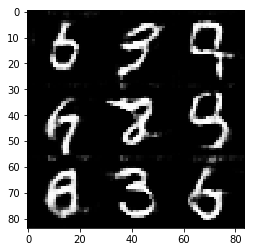

Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.9045
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 1.0323
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 1.0025


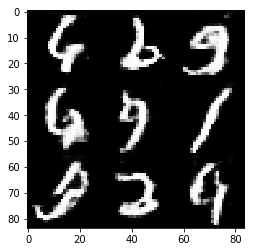

Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 1.0891


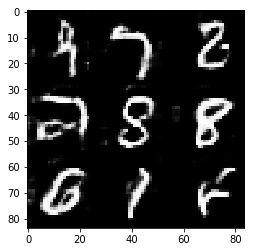

Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.9792
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.9428
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 1.3474
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.9755


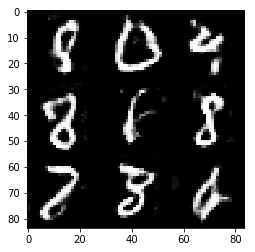

Epoch 2/2... Discriminator Loss: 1.5816... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 1.3664
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 1.0571
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 1.0259


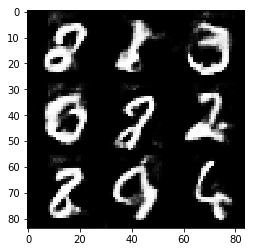

Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 1.0436
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.9251
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.9427


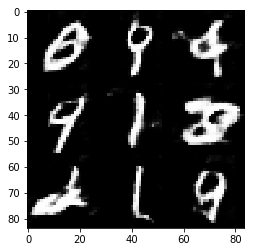

Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 1.4827
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.5620


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 2.1355
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.3039


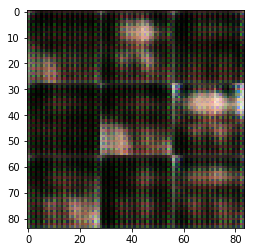

Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8334


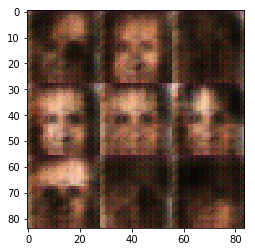

Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.4793


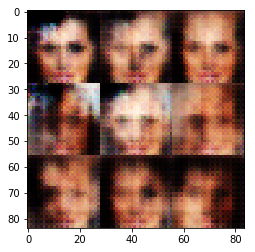

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8799


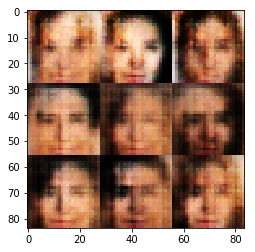

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 2.0475... Generator Loss: 0.2221
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7597


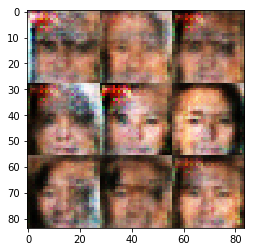

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7568


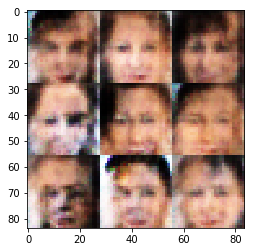

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9405


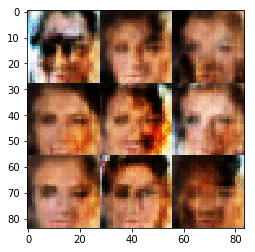

Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7985


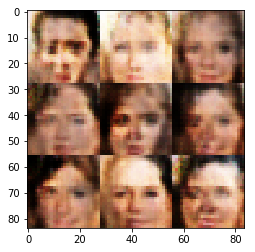

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.8902


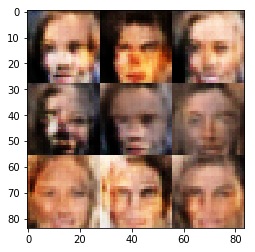

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.9749


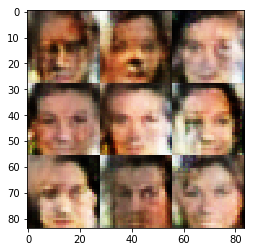

Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7224


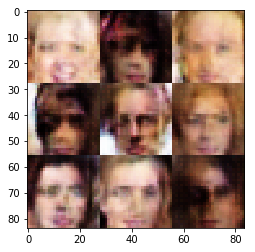

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7737


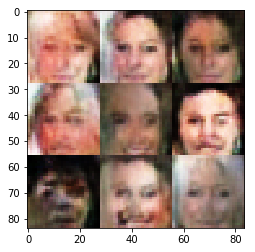

Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8020


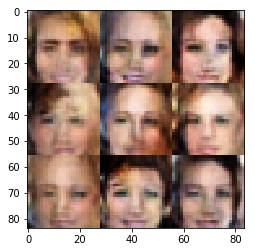

Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8662


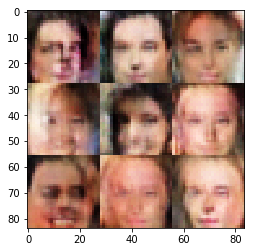

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8865


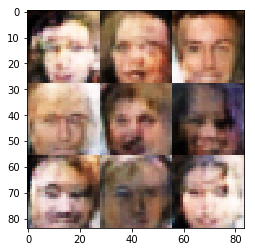

Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.9003


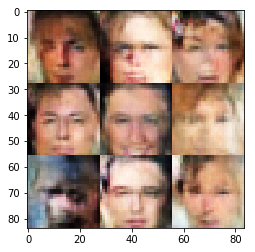

Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8767


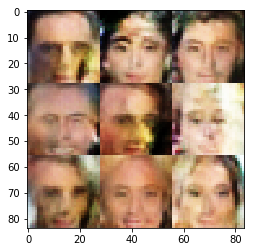

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6927


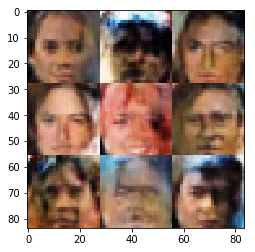

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7080


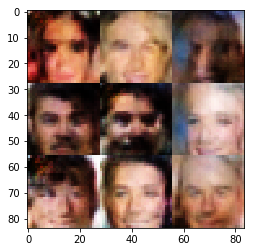

Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7196


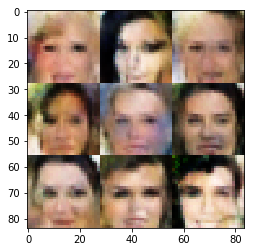

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8850


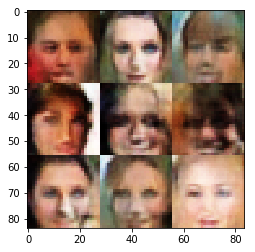

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9031


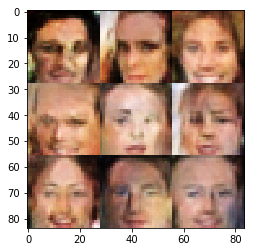

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8191


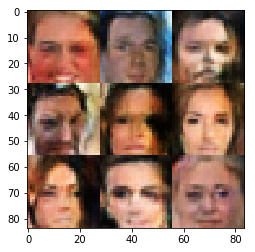

Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7722


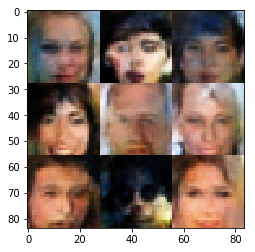

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7326


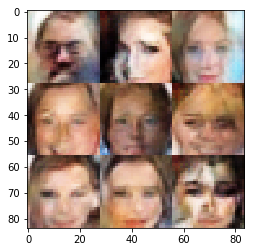

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7976


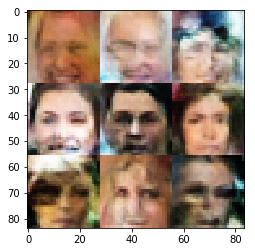

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8922


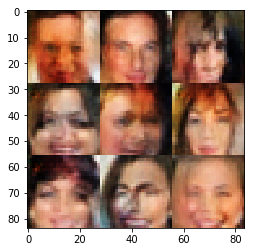

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7767


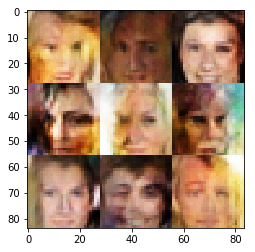

Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7958


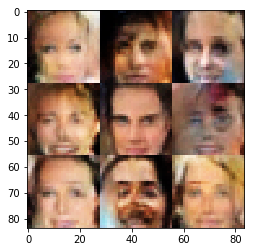

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8346


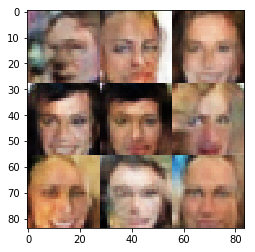

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7404


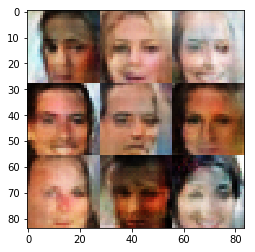

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7431


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.